# Analysis of deep mutational scanning libraries generated by reverse genetics

In the following notebook, I will analyze the deep sequencing data of Perth/2009 H3 HA mutant libraries generated by reverse genetics.

Previously, these mutant virus libraries were generated by a helper-virus approach, as described in [Lee, Huddleston, et al.](http://www.pnas.org/content/early/2018/08/10/1806133115). However, I recently generated and passaged mutant virus libraries using a traditional reverse-genetics approach. Briefly, I seeded co-cultures of 293T & MDCK-SIAT1-TMPRSS2 cells, and transfected the cells with plasmids encoding each of the influenza segments as well as protein expression plasmids for wild-type Perth/2009 HA and the TMPRSS2 protease. Approximately 8 h after transfection, I replaced the media with Influenza Growth Media, and harvested the transfection supernatant ~42 hpt. I then passaged 9e5 variants in MDCK-SIAT1-TMPRSS2 cells at an MOI of 0.005, and changed the media to fresh IGM 3 hpi. Around 40 hpi, I harvested the viral supernatant and ultracentrifuged 24 mL of the supernatant for RNA extraction and subsequent deep sequencing.

# Import modules, define directories

In [24]:
import os
import re
import glob
import subprocess
import itertools
import random
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import collections
import joypy
import statsmodels.stats.multitest
from collections import defaultdict

import dms_tools2
import dms_tools2.sra
import dms_tools2.plot
import dms_tools2.prefs
import dms_tools2.dssp
import dms_tools2.compareprefs
from dms_tools2.ipython_utils import showPDF
import warnings
warnings.simplefilter('ignore') # don't print warnings to avoid clutter in notebook
from IPython.display import display, HTML, Markdown
# from pymodules.utils import * # custom modules for this analysis

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# CPUs to use, should not exceed the number you request with slurm
ncpus = 4

# do we use existing results or generate everything new?
use_existing = 'yes'

inputdir = './data/'
HVstatsdir = os.path.join(inputdir, 'HVlibrary_stats/')

resultsdir = './results/'
fastqdir = os.path.join(resultsdir, 'FASTQ_files/')
countsdir = os.path.join(resultsdir, 'codoncounts/')
prefsdir = os.path.join(resultsdir, 'preferences/')
renumberedprefsdir = os.path.join(resultsdir, 'H3renumberedprefs/')
phydmsdir = os.path.join(resultsdir, 'phydms_analysis/')
HVphydmsdir = os.path.join(resultsdir, 'HVphydms_analysis/')
logodir = os.path.join(resultsdir, 'logoplots/')
plotsdir = os.path.join(resultsdir, 'plots/')

for d in [inputdir, resultsdir, fastqdir, countsdir, prefsdir, renumberedprefsdir,
             phydmsdir, HVphydmsdir, logodir, plotsdir]:
    os.makedirs(d, exist_ok=True)

Using dms_tools2 version 2.3.0


## Get FASTQ files
Symbolically link to the files on the server.

In [2]:
log = !python ./data/symlink_fastq.py
print("Symbolically linked FASTQ files to {0}".format(fastqdir))

Symbolically linked FASTQ files to ./results/FASTQ_files/


## Define the samples

I will create a `pandas` dataframe to define the samples with its corresponding sample name.
The samples include the mutant plasmid library and the mutant virus library as well as the corresponding wildtype plasmid and wildtype virus controls.

In [3]:
samples = pd.DataFrame([('wtDNA', 'WT-pHH-plasmid_R1_*.fastq.gz')] + 
                       [('wtvirus', 'WTvirus_R1_*.fastq.gz')] + 
                       [('mutDNA', 'mutplasmid_R1_*.fastq.gz')] + 
                       [('mutvirus', 'mutvirus_R1_*.fastq.gz')], 
                       columns = ['name', 'R1'])

display(HTML(samples.to_html(index=False)))

name,R1
wtDNA,WT-pHH-plasmid_R1_*.fastq.gz
wtvirus,WTvirus_R1_*.fastq.gz
mutDNA,mutplasmid_R1_*.fastq.gz
mutvirus,mutvirus_R1_*.fastq.gz


## Align deep sequencing data and count mutations

In [4]:
# Reference coding sequence of Perth/2009 HA; from plasmid #1535 pICR2-Perth09-HA
refseq = './data/Perth09_HA_reference.fa'

# Temporary align specs
alignspecs = ' '.join(['1,285,38,40', '286,567,33,34', '568,852,34,30', 
                       '853,1137,34,31', '1138,1422,36,29', '1423,1701,39,44'])

# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
samples.to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 --R2trim 165 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing}

print('Completed dms2_batch_bcsubamp.')


Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


In [5]:
!ls {countsdir}/*_codoncounts.csv

./results/codoncounts//mutDNA_codoncounts.csv
./results/codoncounts//mutvirus_codoncounts.csv
./results/codoncounts//wtDNA_codoncounts.csv
./results/codoncounts//wtvirus_codoncounts.csv


In [26]:
countsplotprefix = os.path.join(countsdir, 'summary')
HVstatsdirprefix = os.path.join(HVstatsdir, 'summary')

For all of the counts plots below, the reverse-genetics library will be displayed on the left or top, and the helper-virus library will be displayed on the right or bottom.

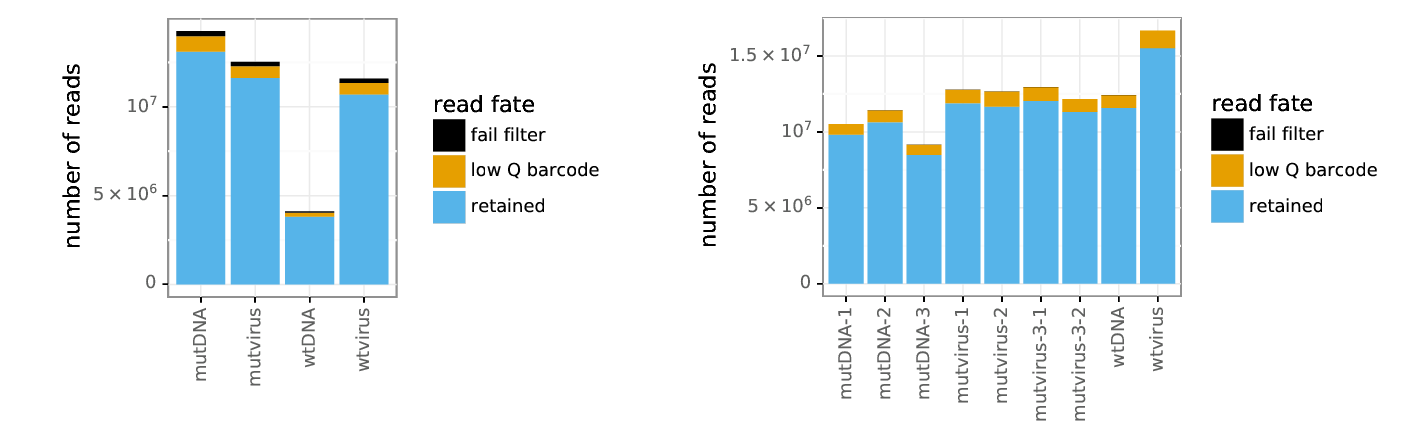

In [28]:
showPDF([countsplotprefix + '_readstats.pdf', HVstatsdirprefix + '_readstats.pdf'])

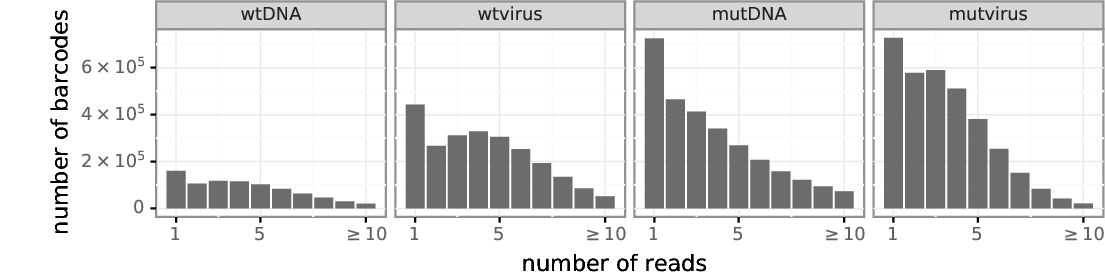

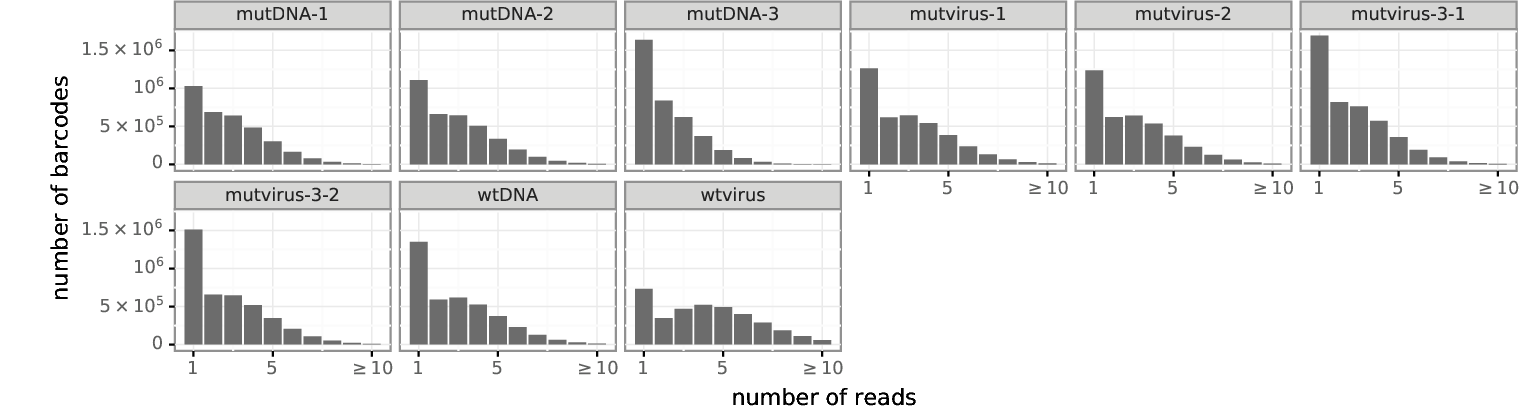

In [30]:
showPDF(countsplotprefix + '_readsperbc.pdf')
showPDF(HVstatsdirprefix + '_readsperbc.pdf')

It appears that the RG mutant plasmid library is somewhat undersequenced. However, the mutant virus library looks like it was sequenced to good depth. The HV mutant plasmid library 3 also looks a bit undersequenced, but the rest of the samples were sequenced to sufficient depth.

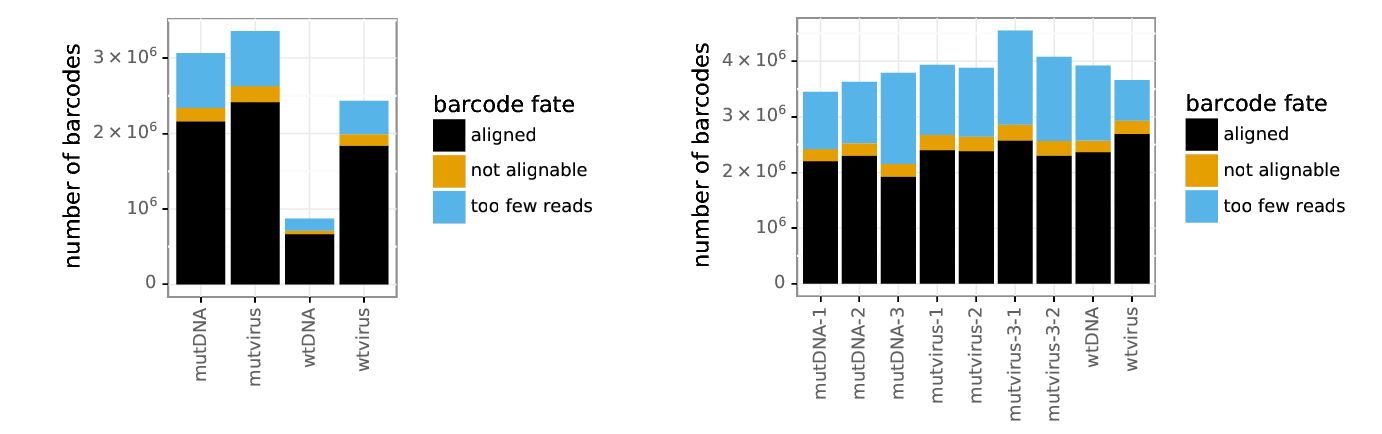

In [31]:
showPDF([countsplotprefix + '_bcstats.pdf', HVstatsdirprefix + '_bcstats.pdf'])

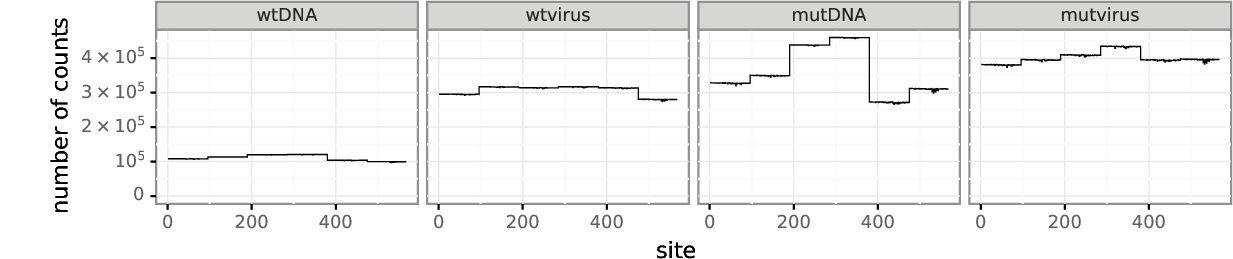

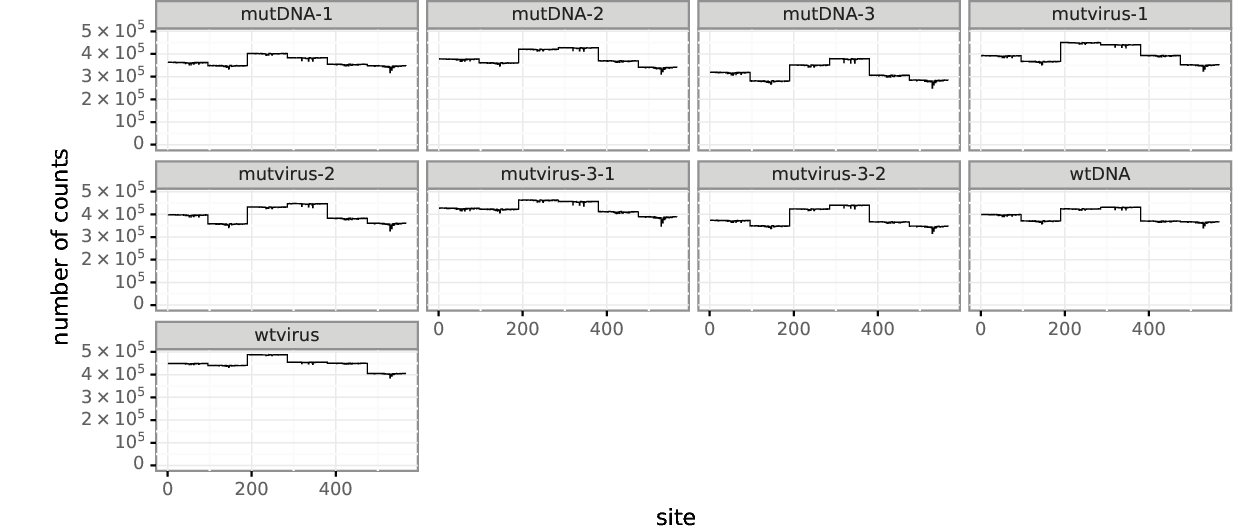

In [32]:
showPDF(countsplotprefix + '_depth.pdf')
showPDF(HVstatsdirprefix + '_depth.pdf')

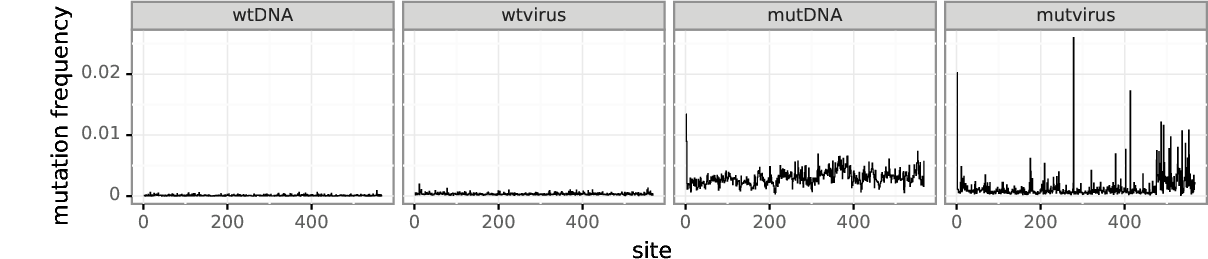

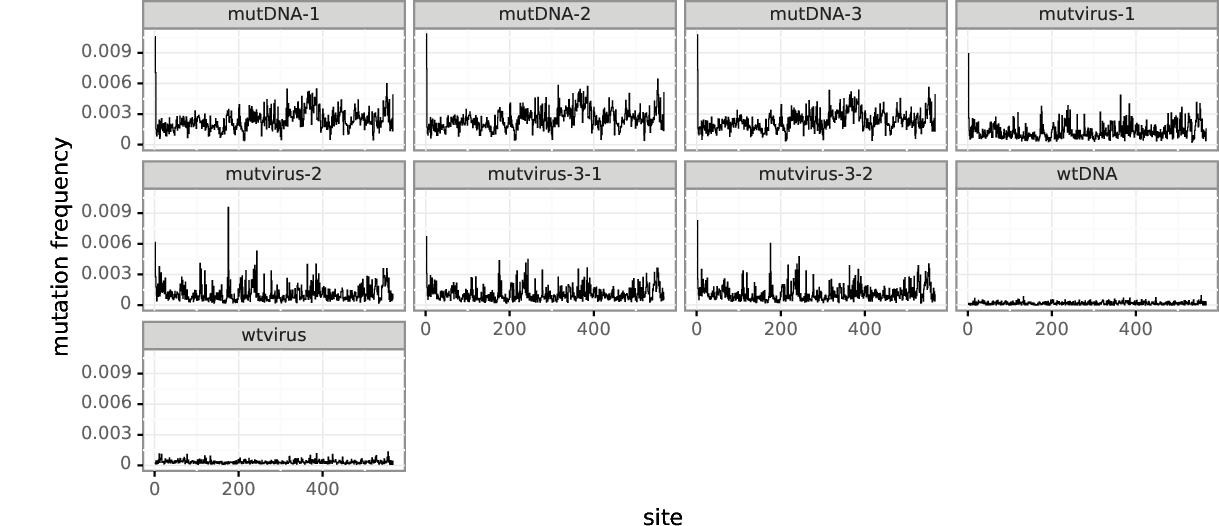

In [33]:
showPDF(countsplotprefix + '_mutfreq.pdf')
showPDF(HVstatsdirprefix + '_mutfreq.pdf')

The RG mutant virus library shows large spikes in mutation frequency at several sites. This could be due to some bottlenecking of variants during the generation of the mutant virus library or during passaging of the library. The RG mutant plasmid library shows a large spike in mutation frequency at the first codon, similarly to each of the HV mutant plasmid libraries. There might be some PCR bias towards mutagenizing the first codon - each of these mutant plasmid libraries were generated independently, and the RG mutant plasmid library is in a different backbone than that of the HV plasmid libraries (pHH vs pICR2, respectively).

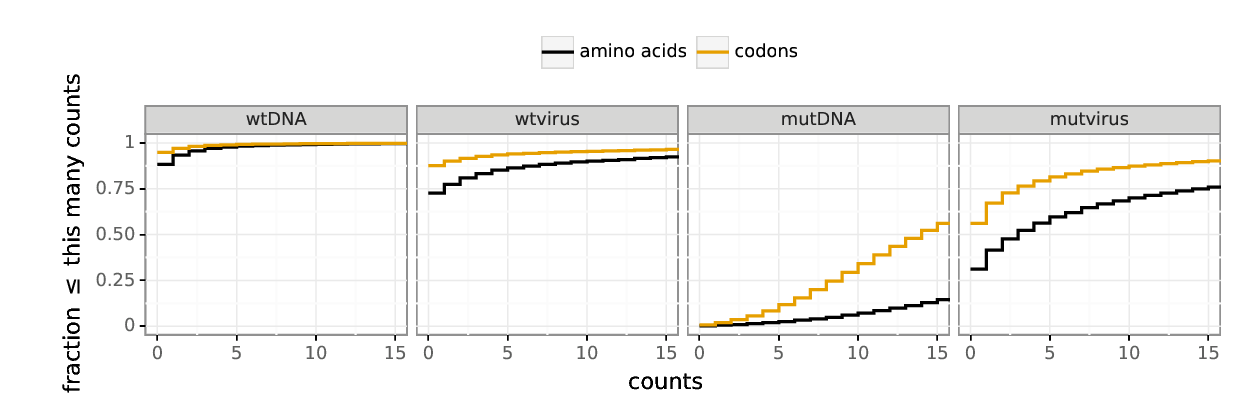

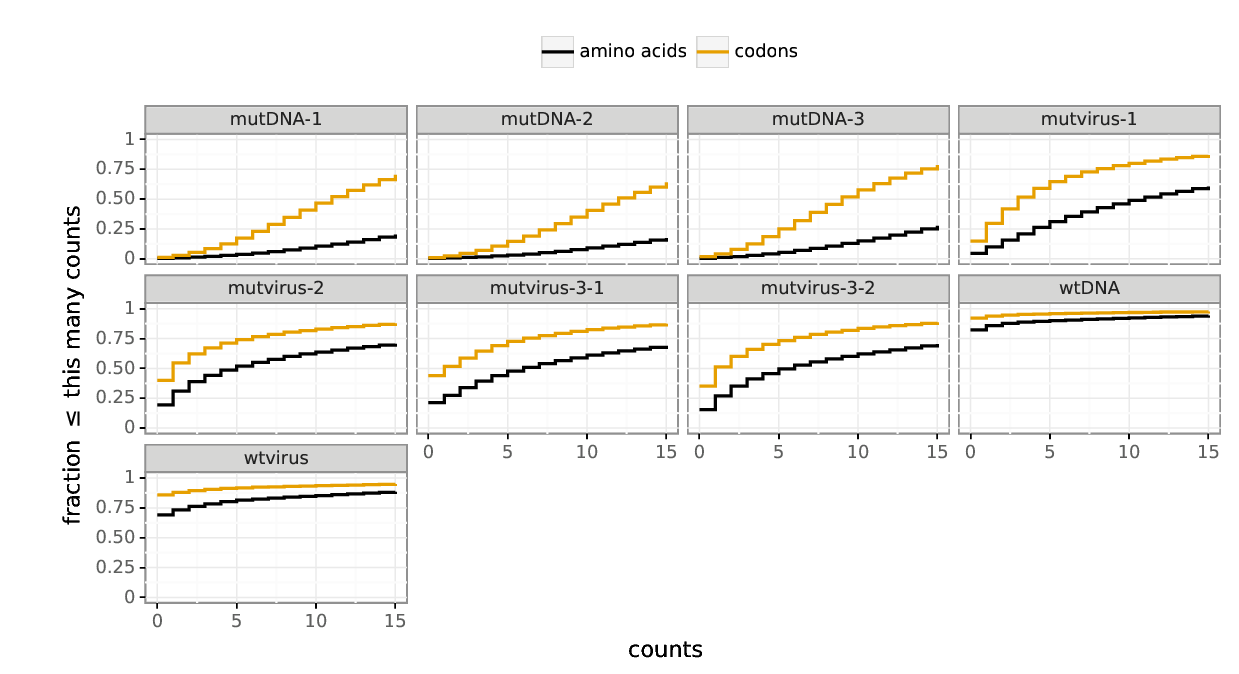

In [34]:
showPDF(countsplotprefix + '_cumulmutcounts.pdf')
showPDF(HVstatsdirprefix + '_cumulmutcounts.pdf')

The RG mutant plasmid library appears to represent nearly all possible amino-acid and codon mutations. However, compared to the HV virus libraries, the RG virus libraries have fewer mutations represented, which again may suggest that these libraries are somewhat bottlenecked compared to the HV libraries.

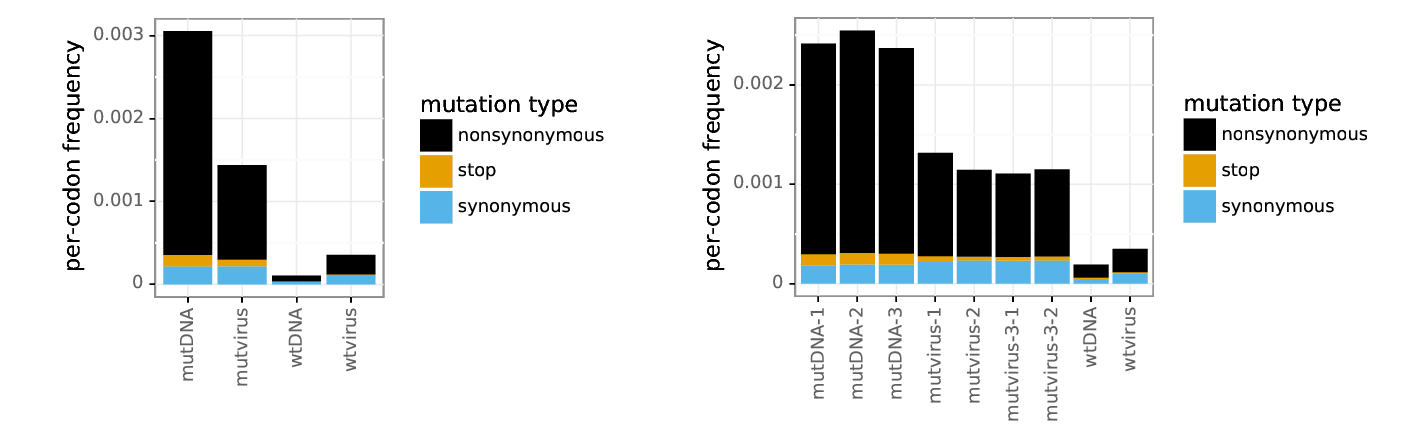

In [35]:
showPDF([countsplotprefix + '_codonmuttypes.pdf', HVstatsdirprefix + '_codonmuttypes.pdf'])

In [14]:
codonmuttypes = pd.read_csv(countsplotprefix + '_codonmuttypes.csv').sort_index(axis=1)
display(HTML(codonmuttypes.to_html(index=False)))

name,nonsynonymous,stop,synonymous
mutDNA,0.002696,0.000138,0.000218
mutvirus,0.001142,0.000078,0.000219
wtDNA,0.000071,0.000004,0.000032
wtvirus,0.000236,0.000009,0.000112


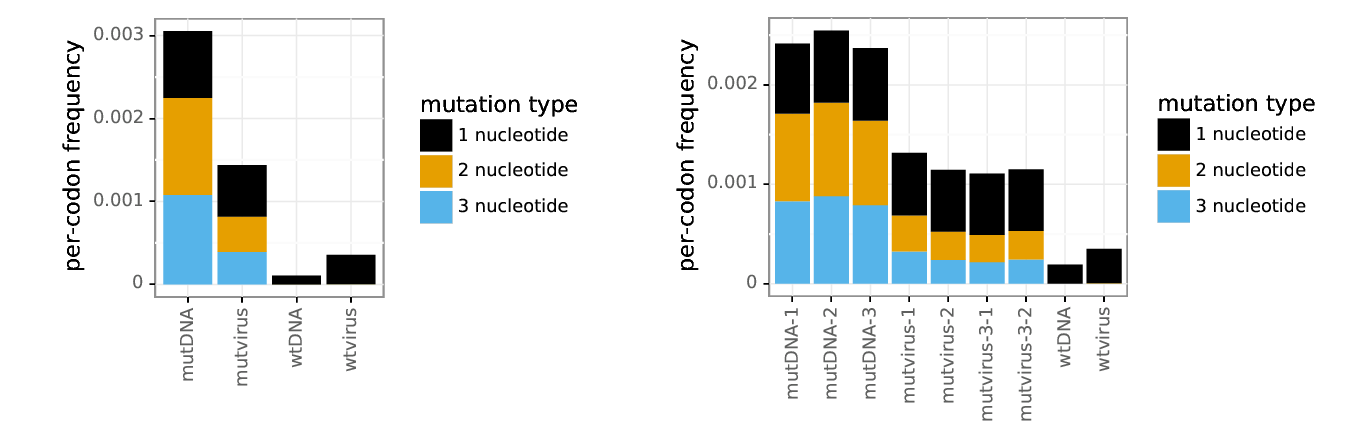

In [36]:
showPDF([countsplotprefix + '_codonntchanges.pdf', HVstatsdirprefix + '_codonntchanges.pdf'])

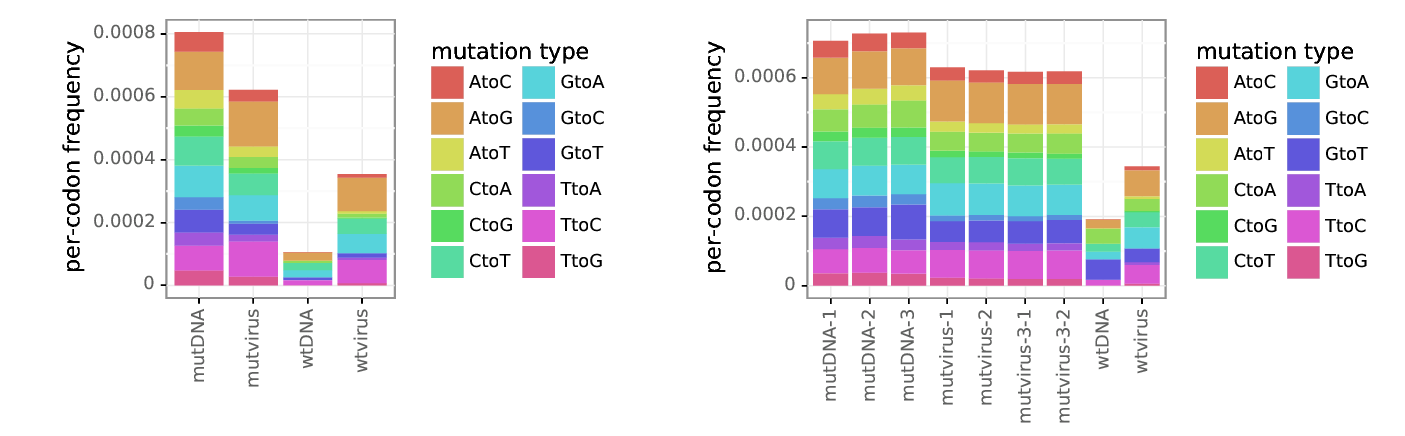

In [37]:
showPDF([countsplotprefix + '_singlentchanges.pdf', HVstatsdirprefix + '_singlentchanges.pdf'])

## Estimate the site-specific amino-acid preferences

Now that we have aligned and counted the mutations for each of our samples, we will now use these counts to estimate the amino-acid preferences for each site in HA.

Our pre-selection samples are the each of the mutDNA-* samples, and the post-selection samples are the mutvirus-* samples. The wtDNA and wtvirus will serve as our "error controls."

In [17]:
# create batch file for dms2_batch_prefs
prefsbatch = pd.DataFrame(
        columns=['name', 'pre', 'post', 'errpre', 'errpost'],
        data=[('rg-replicate-1', 'mutDNA', 'mutvirus', 'wtDNA', 'wtvirus')]
        )
prefsbatchfile = os.path.join(prefsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(prefsbatch.to_html(index=False)))
prefsbatch.to_csv(prefsbatchfile, index=False)

print("Running dms2_batch_prefs...")
log = !dms2_batch_prefs \
        --indir {countsdir} \
        --batchfile {prefsbatchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --use_existing {use_existing} 
print("Completed running dms2_batch_prefs")

Here is the batch file that we write to CSV format to use as input:


name,pre,post,errpre,errpost
rg-replicate-1,mutDNA,mutvirus,wtDNA,wtvirus


Running dms2_batch_prefs...
Completed running dms2_batch_prefs


In [18]:
!ls {prefsdir}/*_prefs.csv

./results/preferences//rg-replicate-1_prefs.csv


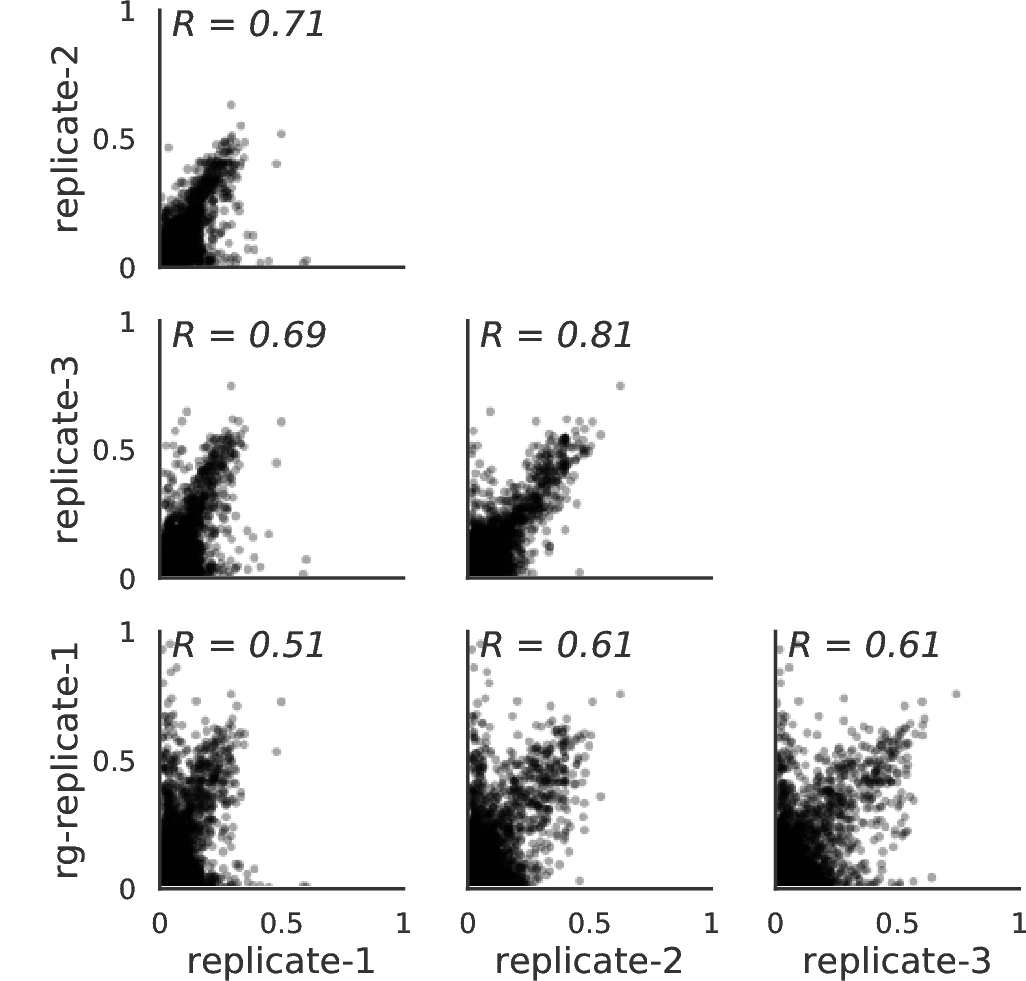

In [19]:
completecorrfile = './results/plots/all_libs_corr.pdf'

dms_tools2.plot.plotCorrMatrix(['rg-replicate-1', 'replicate-1', 'replicate-2', 'replicate-3'], 
                               ['./results/preferences/rg-replicate-1_prefs.csv'] 
                               + glob.glob('./data/replicate-?_prefs.csv'), 
                               completecorrfile, 
                               'prefs')

showPDF(completecorrfile)

## Renumber preferences to H3 numbering and average across replicates

We will now renumber the preferences from sequential (1, 2, ... starting from the initial Met) to H3 numbering. 
The signal peptide is numbered with negative values, and the HA1 and HA2 subunits are numbered separately. 
This numbering scheme is based on an alignment to a PDB structure for an H3 HA [4HMG](https://www.rcsb.org/pdb/explore/explore.do?structureId=4HMG). 
We will use:
1. The [./data/H3renumbering_scheme.csv](./data/H3renumbering_scheme.csv) file to convert the sequential numbers into the H3 numbering scheme
2. The [dms_tools2.utils.renumberSites](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.renumberSites) function to renumber the codon counts files

The renumbered files will be created in a new `H3renumberedprefs` directory and will possess the same names as the original preferences files created from `dms2_batch_bcsuabmp` above.

Before renumbering, we must first average across the two technical replicates of replicate 3. 
After taking the average of the technical replicates, we will renumber the preferences files.
Finally, we will average across the biological replicates.

In [20]:
renumberfile = './data/H3renumbering_scheme.csv'

# preferences files to renumber
prefsfiles = glob.glob('{0}/*_prefs.csv'.format(prefsdir))

dms_tools2.utils.renumberSites(renumberfile, prefsfiles, missing='drop', 
        outdir=renumberedprefsdir)

### Display unscaled preferences

In [21]:
# Domain sites file
domainfile = './data/domains.csv'

# Epitope sites file
epitopefile = './data/wolf_epitope_sites.csv'

In [22]:
seq_wtoverlayfile = os.path.join(prefsdir, 'wildtypeoverlayfile.csv')
aacounts = dms_tools2.utils.codonToAACounts(
        pd.read_csv(os.path.join(countsdir, 'wtDNA_codoncounts.csv')))
aacounts.query('wildtype != "*"')[['site', 'wildtype']].to_csv(
        seq_wtoverlayfile, index=False)

wtoverlayfile = os.path.join(renumberedprefsdir, 'wildtypeoverlayfile.csv')

dms_tools2.utils.renumberSites(renumberfile, [seq_wtoverlayfile], 
        missing='drop', outdir=renumberedprefsdir)

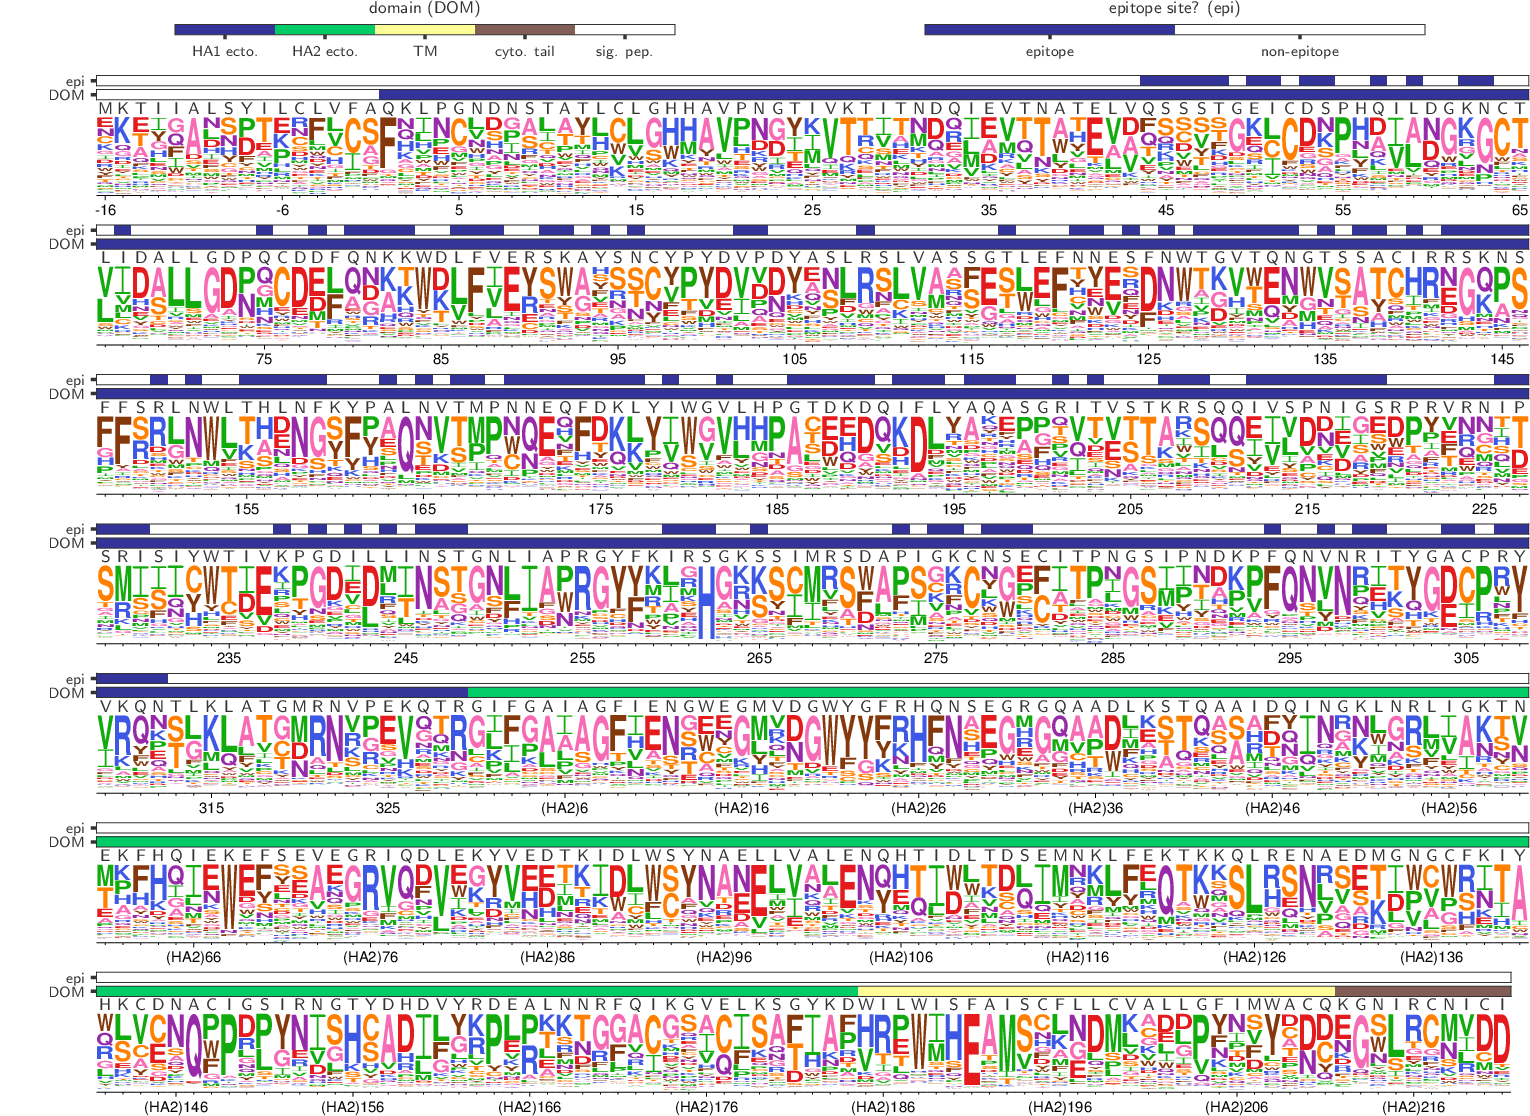

In [23]:
rgLibprefs = './results/H3renumberedprefs/rg-replicate-1_prefs.csv'
logoname = 'rgLib'

log = !dms2_logoplot \
        --prefs {rgLibprefs} \
        --name {logoname} \
        --outdir {logodir} \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --overlay2 {domainfile} DOM "domain" \
        --overlay3 {epitopefile} epi "epitope site?" \
        --overlaycolormap "terrain" \
        --nperline 81 \
        --use_existing {use_existing}
        
logoplot = os.path.join(logodir, '{0}_prefs.pdf'.format(logoname))
showPDF(logoplot)

# Fit preferences to the evolution of natural H3 sequences

We will now use the preferences estimated above and fit these to the natural evolution of human H3N2 and swine H3N2 HA sequences. 
To do so, we will fit an experimentally-informed codon substitution model (ExpCM) (see [Bloom 2014](http://mbe.oxfordjournals.org/content/31/8/1956) and [Hilton and Bloom 2017](https://peerj.com/articles/3657/)) using the preferences and compare the ExpCM with conventional codon substitution models.
We will accomplish this using the [phydms](http://jbloomlab.github.io/phydms/) software ([Hilton and Bloom 2017](https://peerj.com/articles/3657/)).

For the phylogenetic fitting, we will use an alignment of human H3 HA sequences.
We downloaded all full-length human H3N2 HA sequences from the [Influenza Virus Resource](https://www.ncbi.nlm.nih.gov/genomes/FLU/Database/nph-select.cgi?go=database), and subsampled two sequences per year.
We then aligned the sequences using `MAFFT`, and the aligned sequences are in the [./data](./data) directory as `H3_human_alignment.fa`.

Note that [RAxML](https://sco.h-its.org/exelixis/web/software/raxml/index.html) must be available at the path specified in the cell below.

In [42]:
rgLibprefs_seqnum = './results/preferences/rg-replicate-1_prefs.csv'

In [43]:
print("Using the following version of phydms:")
!phydms -v

raxmlpath = 'raxmlHPC-SSE3'
hosts = ['human', 'swine']

for host in hosts:
    alignment = './data/H3_{0}_alignment.fa'.format(host)
    modelcomparison = '{0}/{1}_modelcomparison.md'.format(phydmsdir, host)
    if use_existing == 'yes' and os.path.isfile(modelcomparison):
        print('Results of phydms analysis for {0} alignment already exist.'.format(host))
    else:
        print('Running phydms_comprehensive...')
        outprefix = '{0}/{1}'.format(phydmsdir, host)
        log = !phydms_comprehensive \
               {outprefix} \
               {alignment} \
               {rgLibprefs_seqnum} \
               --raxml {raxmlpath} \
               --omegabysite
        print('Analysis for {0} alignment complete.'.format(host))

Using the following version of phydms:
phydms 2.3.1
Results of phydms analysis for human alignment already exist.
Results of phydms analysis for swine alignment already exist.


In [44]:
print('This is the model comparison using a human alignment:')
modelcomparison = '{0}/human_modelcomparison.md'.format(phydmsdir, host)
display(Markdown(modelcomparison))

This is the model comparison using a human alignment:


| Model                               | deltaAIC | LogLikelihood | nParams | ParamValues                                   |
|-------------------------------------|----------|---------------|---------|-----------------------------------------------|
| ExpCM_rg-replicate-1_prefs          | 0.00     | -8668.90      | 6       | beta=1.33, kappa=5.24, omega=0.82             |
| YNGKP_M5                            | 1638.44  | -9482.12      | 12      | alpha_omega=0.30, beta_omega=0.84, kappa=5.10 |
| averaged_ExpCM_rg-replicate-1_prefs | 2044.66  | -9691.23      | 6       | beta=0.81, kappa=5.59, omega=0.32             |
| YNGKP_M0                            | 2080.30  | -9704.05      | 11      | kappa=5.05, omega=0.31                        |

As a point of comparison, I will also fit an ExpCM for each of the three replicate helper-virus libraries.

In [39]:
reps = ['replicate-{0}'.format(r) for r in range(1,4)]

for rep in reps:
    alignment = './data/H3_human_alignment.fa'
    modelcomparison = '{0}/{1}_modelcomparison.md'.format(HVphydmsdir, rep)
    if use_existing == 'yes' and os.path.isfile(modelcomparison):
        print('Results of phydms analysis for {0} alignment already exist.'.format(rep))
    else:
        print('Running phydms_comprehensive...')
        outprefix = '{0}/{1}'.format(HVphydmsdir, rep)
        prefs = './data/{0}_prefs.csv'.format(rep)
        log = !phydms_comprehensive \
               {outprefix} \
               {alignment} \
               {prefs} \
               --raxml {raxmlpath} \
               --omegabysite
        print('Analysis for {0} alignment complete.'.format(rep))

Results of phydms analysis for replicate-1 alignment already exist.
Results of phydms analysis for replicate-2 alignment already exist.
Results of phydms analysis for replicate-3 alignment already exist.


In [40]:
for rep in reps:
    print('This is the model comparison using a human alignment for {0}:'.format(rep))
    modelcomparison = '{0}/{1}_modelcomparison.md'.format(HVphydmsdir, rep)
    display(Markdown(modelcomparison))

This is the model comparison using a human alignment for replicate-1:


| Model                            | deltaAIC | LogLikelihood | nParams | ParamValues                                   |
|----------------------------------|----------|---------------|---------|-----------------------------------------------|
| ExpCM_replicate-1_prefs          | 0.00     | -8737.14      | 6       | beta=2.37, kappa=5.68, omega=0.73             |
| YNGKP_M5                         | 1501.96  | -9482.12      | 12      | alpha_omega=0.30, beta_omega=0.84, kappa=5.10 |
| averaged_ExpCM_replicate-1_prefs | 1911.72  | -9693.00      | 6       | beta=0.64, kappa=5.60, omega=0.32             |
| YNGKP_M0                         | 1943.82  | -9704.05      | 11      | kappa=5.05, omega=0.31                        |

This is the model comparison using a human alignment for replicate-2:


| Model                            | deltaAIC | LogLikelihood | nParams | ParamValues                                   |
|----------------------------------|----------|---------------|---------|-----------------------------------------------|
| ExpCM_replicate-2_prefs          | 0.00     | -8520.19      | 6       | beta=1.87, kappa=5.63, omega=0.84             |
| YNGKP_M5                         | 1935.86  | -9482.12      | 12      | alpha_omega=0.30, beta_omega=0.84, kappa=5.10 |
| averaged_ExpCM_replicate-2_prefs | 2341.06  | -9690.72      | 6       | beta=0.66, kappa=5.58, omega=0.32             |
| YNGKP_M0                         | 2377.72  | -9704.05      | 11      | kappa=5.05, omega=0.31                        |

This is the model comparison using a human alignment for replicate-3:


| Model                            | deltaAIC | LogLikelihood | nParams | ParamValues                                   |
|----------------------------------|----------|---------------|---------|-----------------------------------------------|
| ExpCM_replicate-3_prefs          | 0.00     | -8518.52      | 6       | beta=2.14, kappa=5.75, omega=0.86             |
| YNGKP_M5                         | 1939.20  | -9482.12      | 12      | alpha_omega=0.30, beta_omega=0.84, kappa=5.10 |
| averaged_ExpCM_replicate-3_prefs | 2345.26  | -9691.15      | 6       | beta=0.70, kappa=5.58, omega=0.32             |
| YNGKP_M0                         | 2381.06  | -9704.05      | 11      | kappa=5.05, omega=0.31                        |

## Display preferences as a rescaled logoplot

I will use the rescaling parameter ( $\beta$ ) from `phydms_comprehensive` to create logoplots of rescaled preferences.
First, I will read in the beta values from the `ExpCM *_modelparams.txt` file.

In [20]:
params_file = open('{0}/human_ExpCM_rg-replicate-1_prefs_modelparams.txt'
        .format(phydmsdir), 'r')
params_lst = [line.rstrip() for line in params_file.readlines()]
params_file.close()
beta = float([line for line in params_lst if 'beta' in line][0][7:])
print ('Beta parameter for ExpCM for the averaged preferences = {0}'.format(beta))

Beta parameter for ExpCM for the averaged preferences = 1.32963


## Re-scale the preferences

In [32]:
unscaled_prefsdf = pd.read_csv(rgLibprefs)
rescaled_prefsdf = dms_tools2.prefs.rescalePrefs(unscaled_prefsdf, beta)

rescaledavgprefs = os.path.join(renumberedprefsdir, 'rgLib_prefs_rescaled.csv')
rescaled_prefsdf.to_csv(rescaledavgprefs, index=False)

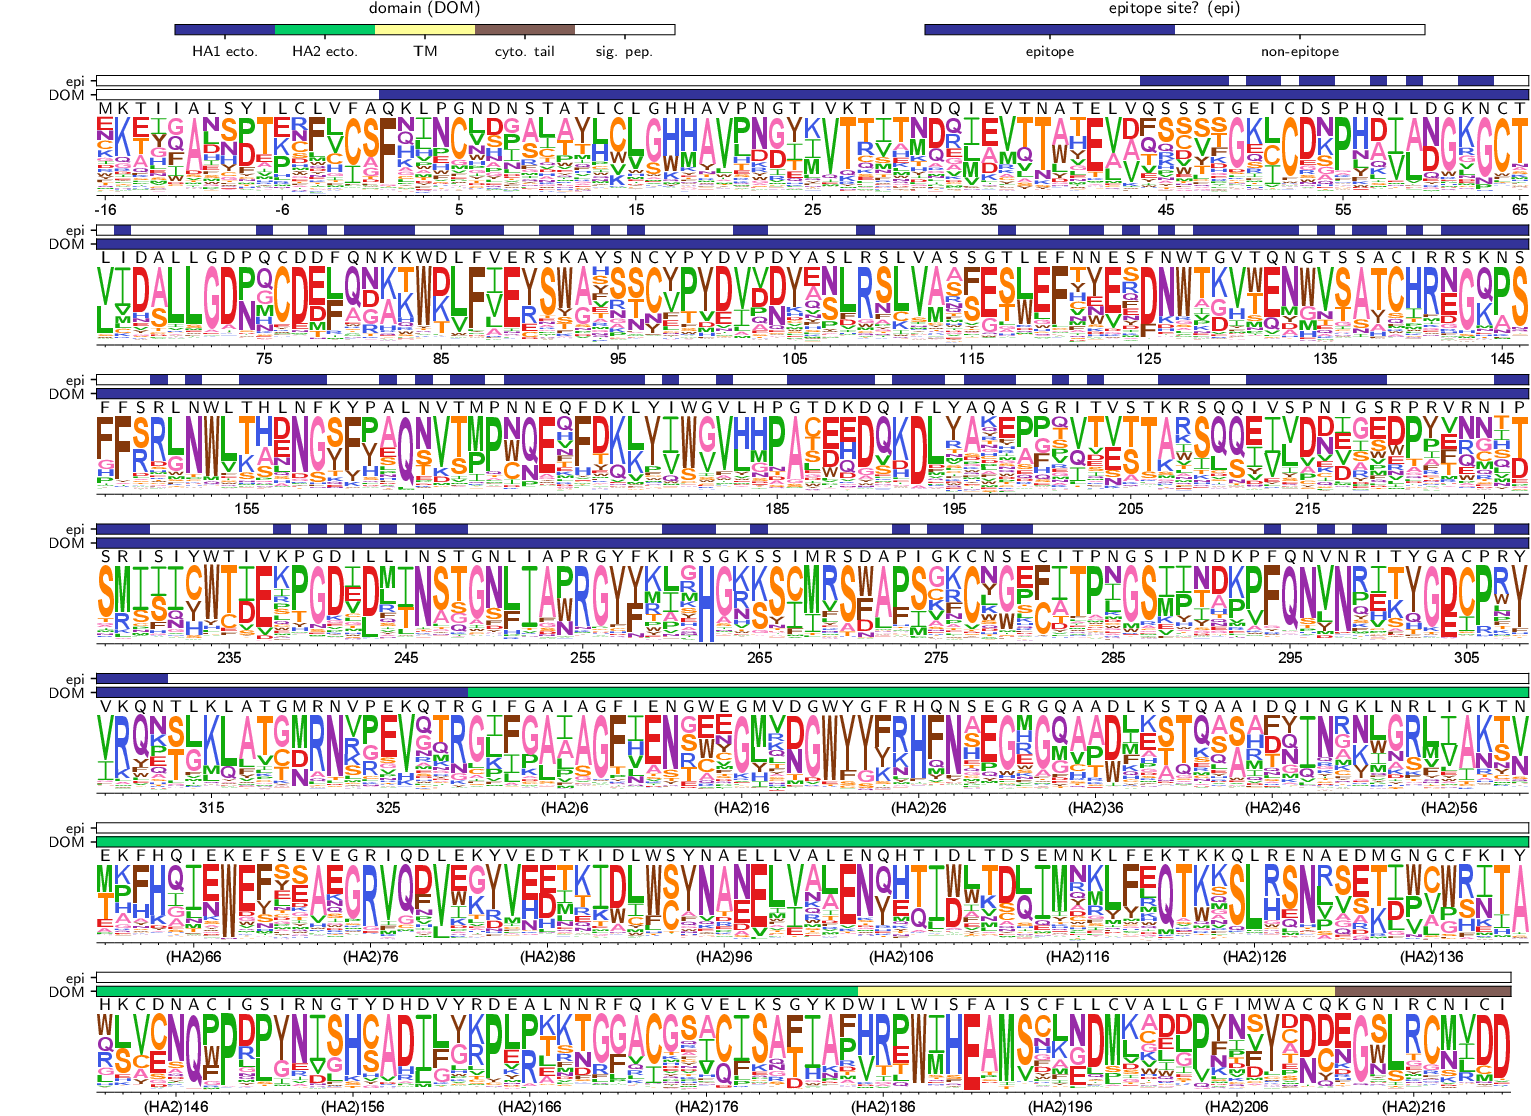

In [33]:
rescaledlogoname = 'rgLib-rescaled'

log = !dms2_logoplot \
        --prefs {rescaledavgprefs} \
        --name {rescaledlogoname} \
        --outdir {logodir} \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --overlay2 {domainfile} DOM "domain" \
        --overlay3 {epitopefile} epi "epitope site?" \
        --overlaycolormap "terrain" \
        --nperline 81 \
        --use_existing {use_existing}
        
rescaledlogoplot = os.path.join(logodir, '{0}_prefs.pdf'.format(rescaledlogoname))
showPDF(rescaledlogoplot)